# Survival Probability $S(t)$ Data Generation

## Import Packages & Figure settings

In [2]:
#Import the necessary packages
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pickle

#from qutip import * 
import networkx as nx
from tqdm import tqdm
import multiprocessing as mp
import pickle 
import scipy.linalg as la
from multiprocessing import Pool
from joblib import Parallel, delayed

mpl.rcParams['font.family'] = 'serif' #'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1

#Set options for later computations - we will probably not need this!
#options = Options(nsteps=int(1e6), normalize_output=False, atol=1e-9, rtol=1e-7)
#Function to change the plot axes, set the plot range, and tick mark intervals. 
#Function takes in an axis object, and the plot range in the form of a list [[x_min, x_max],[y_min, y_max]], and 
#tick marks [x ticks major interval, x ticks minor interval, y ticks major interval, y ticks minor interval]
def plot_settings(ax=None, plot_range=[], ticks=[], framed=True):
    #If no axis object is given, take the last set of active plot axes
    if ax is None:
        ax = plt.gca()
    #Plot formatting
    if framed==False:
        ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False) #Hide the top and right spines of the axis
    if plot_range:
        ax.set_xlim(plot_range[0][0], plot_range[0][1]); ax.set_ylim(plot_range[1][0], plot_range[1][1]) #Set the plot range of the axes
    # Edit the major and minor ticks of the x and y axes - linewidth, size, direction 
    ax.xaxis.set_tick_params(which='major', size=6, width=1, direction='in')
    ax.xaxis.set_tick_params(which='minor', size=3, width=0.8, direction='in')
    ax.yaxis.set_tick_params(which='major', size=6, width=1, direction='in')
    ax.yaxis.set_tick_params(which='minor', size=3, width=0.8, direction='in')
    #Set intervals between ticks
    if ticks:
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(ticks[0]))
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(ticks[1]))
        ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(ticks[2]))
        ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(ticks[3]))
    #ax.plot(x, y, **plt_kwargs) ## example plot here
    return(ax)

## Generate Datasets

### Definitions

In [2]:
def H_CG(N, gamma, w, kappa):
    """
    Generate the Hamiltonian for search on the Complete Graph with a sink at target site.
    
    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        w (int): Target node/site location; dynamics invariant under choice of w.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.
        
    Returns:
        np.ndarray: The resulting Hamiltonian in matrix form.
    """
    ket_s = np.ones((N, 1)) / np.sqrt(N) # Initial state (uniform superposition)
    H = -gamma * N * ket_s @ ket_s.T.conj() # Hamiltonian matrix of complete graph
    H = H.astype(complex)
    H[w, w] -= (1 + 1j * kappa)  # Target site
    return H.astype(complex)

def surv_prob(Tcutoff, dt, r, N, gamma, w, kappa):
    """
    Compute the survival probability as a function of time.
    
    Args:
        Tcutoff (float): Cutoff time for the dynamics.
        dt (float): Discretization of time into time steps of duration dt.
        r (int): reset value (such that the time after which we reset is t_reset = r*dt).
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        w (int): Target node/site location; dynamics invariant under choice of w.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.
        
    Returns:
        np.ndarray: Survival probabilities.
    """
    m = int(Tcutoff / dt)  # Number of time steps, each with duration dt
    H = H_CG(N, gamma, w, kappa) # Get search Hamiltonian
    psi_0 = np.ones((N, 1)) / np.sqrt(N)  # Initial state (uniform superposition)
    psi_r = psi_0.copy()  # Reset state
    
    s_prob = np.zeros(m) # Initialize array
    s_prob[0] = 1.0  # Initial survival probability
    
    ut = la.expm(-1j * H * dt)  # Time evolution operator

    for j in range(1, m): 
        psit = ut @ psi_0
        s_prob[j] = np.vdot(psit, psit).real  # Survival probability

        if r == 0: #No reset condition
            psi_0 = psit
        else:
            if j%r != 0:  #normal condition    
                psi_0 = psit  
            else: # reset conditions
                psi_0 = np.sqrt(s_prob[j])*psi_r

    return s_prob

def find_transition_point(arr, dt): # EMMA
    """
    Find the first time index where the survival probability (SP) drops below 0.5.
    
    Args:
        arr (numpy array): Array of survival probability values.
        dt (float): Discretization of time into time steps of duration dt.
        
    Returns:
        float: Time at which SP drops below the value of 1/2.
    """
    idx = np.where(arr <= 0.5)[0]
    return idx[0] * dt if len(idx) > 0 else 0  # Return first occurrence or 0

def find_transition_point2(arr, dt): # SAYAN
    left, right = 0, len(arr) - 1
    
    while left < right:
        mid = (left + right) // 2
        if arr[mid] > 0.5:
            left = mid + 1  # Search in the right half
        else:
            right = mid  # Search in the left half
            
    return left * dt if arr[left] <= 0.5 else 0  # Return index or 0 if no transition

### Single-core processing

In [7]:
# Parameters
Tcutoff = 400
dt = 0.05
r_vals = np.linspace(1, (Tcutoff+1)/dt, 20, dtype=int)
kappa_vals = np.linspace(0, 0.4, 20)
N = 100  # System size
w = 10  # Target site
gamma_vals = np.linspace(0.8/N, 1.2/N, 20)

# Storage Arrays
T_decay0p5 = np.zeros((len(gamma_vals), len(kappa_vals), len(r_vals)))
s_prob_arr = np.zeros((len(gamma_vals), len(kappa_vals), len(r_vals), int(Tcutoff / dt)))

# Compute Survival Probabilities and Transition Points
for gg, gamma in tqdm(enumerate(gamma_vals), total=len(gamma_vals)):
    for kk, kappa in enumerate(kappa_vals):
        for rr, r in enumerate(r_vals):
            s_prob = surv_prob(Tcutoff, dt, r, N, gamma, w, kappa)
            s_prob_arr[gg, kk, rr] = s_prob
            #print(find_transition_point2(s_prob, dt),gamma,kappa,r)
            T_decay0p5[gg, kk, rr] = find_transition_point(s_prob, dt)
            
#filename = f"survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}.pkl"
#dict_to_save = [gamma_vals, kappa_vals, r_vals, s_prob_arr, T_decay0p5]

#with open(filename, 'wb') as f:
#    pickle.dump(dict_to_save, f)

100%|██████████| 20/20 [09:51<00:00, 29.56s/it]


Some consistency checks and figures...

In [3]:
Tcutoff = 400; dt = 0.05; N = 500
filename = f"../Data/survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}_NO_SPROB.pkl"
#dict_to_save = [gamma_vals, kappa_vals, r_vals, s_prob_arr, T_decay0p5]
with open(filename, 'rb') as f:
    data = pickle.load(f)
gamma_vals, kappa_vals, r_vals, T_decay0p5 = data

In [4]:
# Extract optimal reset rate and minimum search times --- TO BE VERIFIED LATER!!!
T_min = np.zeros((len(gamma_vals), len(kappa_vals)))
r_optimal = np.zeros((len(gamma_vals), len(kappa_vals)))
T_decay0p5 = np.where(T_decay0p5==0, np.inf, T_decay0p5)

for gg in tqdm(range(len(gamma_vals))):
    for kk in range(len(kappa_vals)):
        T_decay_temp = T_decay0p5[gg, kk]
        if len(T_decay_temp) > 0:
            T_min[gg, kk] = np.min(T_decay_temp)
            r_optimal[gg, kk] = r_vals[np.argmin(T_decay_temp)]
        else:
            T_min[gg, kk] = np.nan  # Mark undefined cases
            r_optimal[gg, kk] = np.nan


100%|██████████| 100/100 [00:00<00:00, 4037.72it/s]


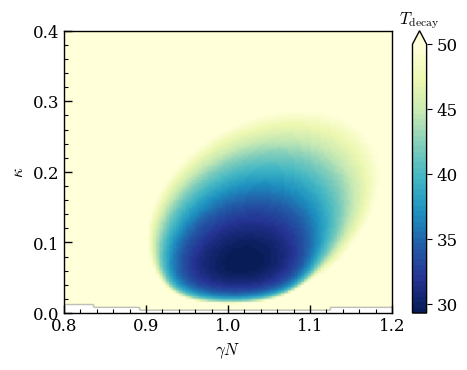

In [15]:
# Visualization - Minimum search time heatmap & Optimal reset rate heatmap
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
im1 = ax1.imshow(T_min.T, origin='lower', aspect='auto',
                 extent=[gamma_vals[0]*N, gamma_vals[-1]*N,kappa_vals[0], kappa_vals[-1]],
                 cmap=plt.get_cmap('YlGnBu_r',50), vmax=50)
ax1.set_ylabel(r"$\kappa$")
ax1.set_xlabel(r"$\gamma N$")
#ax1.set_title("Minimum search time $T_{\min}$")
cbar = fig.colorbar(im1, ax=ax1, extend = "max")
cbar.ax.set_title(r'$T_{\rm decay}$', size = 12,pad = 15)

plot_settings(ax1,[[0.8,1.2],[0,0.4]],[0.1,0.02,0.1,0.02],True)

#ax2 = axes[1]
#im2 = ax2.imshow(r_optimal.T, origin='lower', aspect='auto',
#                 extent=[gamma_vals[0]*N, gamma_vals[-1]*N, kappa_vals[0], kappa_vals[-1]],
#                 cmap=plt.get_cmap('YlGnBu_r',300), vmax=400)
#ax2.set_ylabel(r"$\kappa$")
#ax2.set_xlabel(r"$\gamma N$")
#ax2.set_title("Optimal reset rate $r_{\mathrm{opt}}$")
#fig.colorbar(im2, ax=ax2, extend = "max")
#plot_settings(ax2,[[0.8,1.2],[0,0.4]],[0.1,0.02,0.1,0.02],True)

plt.tight_layout()

plt.savefig('../Figures/Final/decay_time_sprob.pdf', bbox_inches ='tight', transparent = True, dpi = 800)
plt.show()

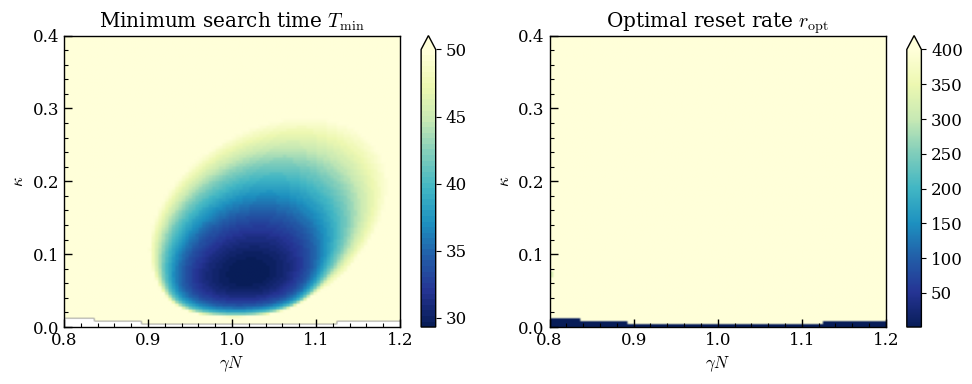

In [6]:
# Visualization - Minimum search time heatmap & Optimal reset rate heatmap
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax1 = axes[0]
im1 = ax1.imshow(T_min.T, origin='lower', aspect='auto',
                 extent=[gamma_vals[0]*N, gamma_vals[-1]*N,kappa_vals[0], kappa_vals[-1]],
                 cmap=plt.get_cmap('YlGnBu_r',50), vmax=50)
ax1.set_ylabel(r"$\kappa$")
ax1.set_xlabel(r"$\gamma N$")
ax1.set_title("Minimum search time $T_{\min}$")
fig.colorbar(im1, ax=ax1, extend = "max")
plot_settings(ax1,[[0.8,1.2],[0,0.4]],[0.1,0.02,0.1,0.02],True)

ax2 = axes[1]
im2 = ax2.imshow(r_optimal.T, origin='lower', aspect='auto',
                 extent=[gamma_vals[0]*N, gamma_vals[-1]*N, kappa_vals[0], kappa_vals[-1]],
                 cmap=plt.get_cmap('YlGnBu_r',300), vmax=400)
ax2.set_ylabel(r"$\kappa$")
ax2.set_xlabel(r"$\gamma N$")
ax2.set_title("Optimal reset rate $r_{\mathrm{opt}}$")
fig.colorbar(im2, ax=ax2, extend = "max")
plot_settings(ax2,[[0.8,1.2],[0,0.4]],[0.1,0.02,0.1,0.02],True)

plt.tight_layout()
plt.show()

In [16]:
Tcutoff = 400; dt = 0.05; Nlist = [50,74,100,124,150,174,200,224,250,300,324,350,374,424,450,500]

runtimes = np.zeros(len(Nlist))
gammaN_opts = np.zeros(len(Nlist))
kappa_opts = np.zeros(len(Nlist))

for j, N in enumerate(Nlist):
    filename = f"../Data/survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}_NO_SPROB.pkl"
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    gamma_vals, kappa_vals, r_vals, T_decay0p5 = data

    T_min = np.zeros((len(gamma_vals), len(kappa_vals)))
    r_optimal = np.zeros((len(gamma_vals), len(kappa_vals)))
    T_decay0p5 = np.where(T_decay0p5==0, np.inf, T_decay0p5)

    for gg in tqdm(range(len(gamma_vals))):
        for kk in range(len(kappa_vals)):
            T_decay_temp = T_decay0p5[gg, kk]
            if len(T_decay_temp) > 0:
                T_min[gg, kk] = np.min(T_decay_temp)
                r_optimal[gg, kk] = r_vals[np.argmin(T_decay_temp)]
            else:
                T_min[gg, kk] = np.nan  # Mark undefined cases
                r_optimal[gg, kk] = np.nan

    id = np.unravel_index(T_min.argmin(), T_min.shape)
    runtimes[j] = T_min[np.unravel_index(T_min.argmin(), T_min.shape)]
    gammaN_opts[j] = gamma_vals[id[0]]*N
    kappa_opts[j] = kappa_vals[id[1]]

100%|██████████| 100/100 [00:00<00:00, 3371.06it/s]


In [19]:
def timeScaling(Nlist):
    return [np.sqrt(N) for N in Nlist]

data = timeScaling(Nlist)

/tmp/ipykernel_2309613/4276976866.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


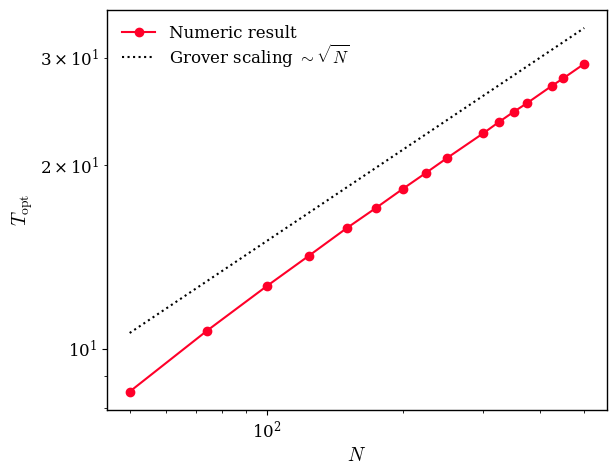

In [38]:
fig = plt.figure(figsize=(5,4)) #Generate figure with a given size
ax = fig.add_axes([0, 0, 1, 1]) #Add axes object to our figure that takes up entire figure

colors = plt.get_cmap('gist_rainbow', 16)
plt.plot(Nlist, runtimes, color=colors(0), marker='o', linestyle='-', label="Numeric result")
plt.plot(Nlist, 1.5*np.array(data), color="k", ls=":", label=r"Grover scaling $\sim \sqrt{N}$")
plt.xlabel(r"$N$",size = 14) #x-axis label
plt.ylabel(r"$T_{\mathrm{opt}}$", size = 14) #y-axis label
plt.legend(loc= 0, prop={'size': 12}, labelspacing=0.01, frameon=False)
plt.yscale('log')
plt.xscale('log')
#filename = f"Overlaps_figure_N{N}_dim{d}_alpha{alpha_str}.pdf"

plt.tight_layout()
plt.savefig("../Figures/Final/CompleteGraphTopt.pdf", dpi=800, transparent=True, bbox_inches='tight')
plt.show()

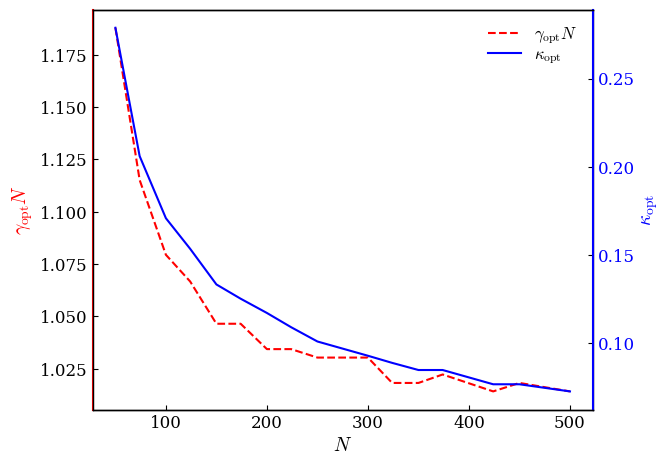

In [42]:
fig = plt.figure(figsize=(5,4))  # Same size as the first plot
ax1 = fig.add_axes([0, 0, 1, 1])  # Primary axis

# Energy curves on the primary y-axis
ax1.plot(Nlist, gammaN_opts, label=r"$\gamma_{\rm opt} N$", color="red", ls="--")

# Primary axis settings
ax1.set_xlabel(r"$N$", size =14)
#plt.title(r"Optimal parameter values", color="black")
ax1.set_ylabel(r"$\gamma_{\rm opt} N$", color="red", size = 14)
ax1.tick_params(axis="both", direction="in", labelcolor="black")
ax1.spines["left"].set_color("red")
ax1.spines["left"].set_linewidth(1.5)

# Add a secondary y-axis for purity
ax2 = ax1.twinx()
ax2.plot(Nlist, kappa_opts, label=r"$\kappa_{\rm opt}$", color="blue", linestyle="-")
ax2.set_ylabel(r"$\kappa_{\rm opt}$", color="blue", size = 14)
ax2.tick_params(axis="y", direction="in", labelcolor="blue")
ax2.spines["right"].set_color("blue")
ax2.spines["right"].set_linewidth(1.5)

# Combined legend
lns1, labels1 = ax1.get_legend_handles_labels()
lns2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lns1 + lns2, labels1 + labels2, loc="upper right", prop={'size': 12}, labelspacing=0.01, frameon=False)

#plt.tight_layout()

plt.savefig("../Figures/Final/CompleteGraph_gamma_kappa_opt.pdf", dpi=800, transparent=True, bbox_inches='tight')
plt.show()

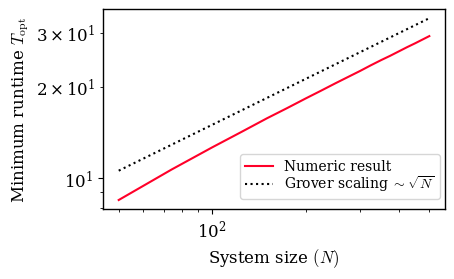

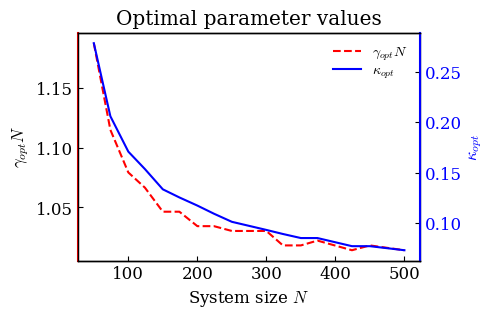

In [17]:
def timeScaling(Nlist):
    return [np.sqrt(N) for N in Nlist]

data = timeScaling(Nlist)

fig = plt.figure(figsize=(3.41667, 2)) #Generate figure with a given size
ax = fig.add_axes([0, 0, 1, 1]) #Add axes object to our figure that takes up entire figure
#plot_settings_Framed(ax, [[10.0,1000],[1,100]], [25,5,0.25,0.05])
colors = plt.get_cmap('gist_rainbow', 16)

plt.plot(Nlist, runtimes, color=colors(0), ls="-", label="Numeric result")
plt.plot(Nlist, 1.5*np.array(data), color="k", ls=":", label=r"Grover scaling $\sim \sqrt{N}$")
plt.xlabel(r"System size $(N)$") #x-axis label
plt.ylabel(r"Minimum runtime $T_{\mathrm{opt}}$") #y-axis label
plt.legend(loc=(0.4,0.05), prop={'size': 10}, labelspacing=0.01, frameon=True)
plt.yscale('log')
plt.xscale('log')
#filename = f"Overlaps_figure_N{N}_dim{d}_alpha{alpha_str}.pdf"
#plt.savefig("CompleteGraphTopt.pdf", dpi=300, transparent=True, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(3.41667, 2*3.41667/3))
ax1 = fig.add_axes([0, 0, 1, 1])  # Primary axis
#plot_settings_Framed(ax1,[],[20,4,2,0.4])

# Energy curves on the primary y-axis
ax1.plot(Nlist, gammaN_opts, label=r"$\gamma_{opt} N$", color="red", ls="--")

# Primary axis settings
ax1.set_xlabel(r"System size $N$")
plt.title(r"Optimal parameter values", color="black")
ax1.set_ylabel(r"$\gamma_{opt} N$", color="black")
ax1.tick_params(axis="both", direction="in", labelcolor="black")
ax1.spines["left"].set_color("red")
ax1.spines["left"].set_linewidth(1.5)

# Add a secondary y-axis for purity
ax2 = ax1.twinx()  # Twin axis sharing the same x-axis
ax2.plot(Nlist, kappa_opts, label=r"$\kappa_{opt}$", color="blue", linestyle="-")
ax2.set_ylabel(r"$\kappa_{opt}$", color="blue")  # Label for the secondary axis
ax2.tick_params(axis="y", direction="in", labelcolor="blue")

# Change the axis line color to blue for the purity axis
ax2.spines["right"].set_color("blue")
ax2.spines["right"].set_linewidth(1.5)

# Combined legend
lns1, labels1 = ax1.get_legend_handles_labels()
lns2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lns1 + lns2, labels1 + labels2, loc="upper right", prop={'size': 10}, labelspacing=0.01, frameon=False)

#ax2.set_yscale('log')
#ax1.set_yscale('log')
#ax1.set_xscale('log')

plt.show()

In [6]:
kappa_opts*Nlist

array([13.93939394, 15.24848485, 17.08542714, 19.03838384, 20.        ,
       21.79393939, 23.43434343, 24.43636364, 25.25252525, 27.87878788,
       28.8       , 29.6969697 , 31.73333333, 32.54949495, 34.54545455,
       36.36363636])

In [7]:
kappa_opts

array([0.27878788, 0.20606061, 0.17085427, 0.15353535, 0.13333333,
       0.12525253, 0.11717172, 0.10909091, 0.1010101 , 0.09292929,
       0.08888889, 0.08484848, 0.08484848, 0.07676768, 0.07676768,
       0.07272727])

In [8]:
Nlist

[50, 74, 100, 124, 150, 174, 200, 224, 250, 300, 324, 350, 374, 424, 450, 500]

0.002004040404040404


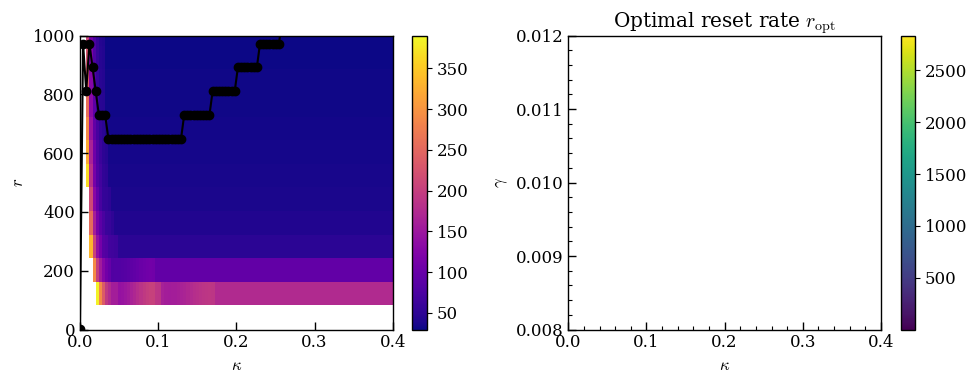

In [12]:
# Visualization - Minimum search time heatmap & Optimal reset rate heatmap
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax1 = axes[0]
print(gamma_vals[50])
im1 = ax1.imshow(np.real(T_decay0p5[50]), origin='lower', aspect='auto',
                 extent=[kappa_vals[0], kappa_vals[-1], r_vals[0], r_vals[-1]],
                 cmap='plasma')
ax1.plot(kappa_vals,r_optimal[50],marker="o",color="k")
ax1.set_xlabel(r"$\kappa$")
ax1.set_ylabel(r"$r$")
#ax1.set_title("Minimum search time $T_{\min}$")
fig.colorbar(im1, ax=ax1)
plot_settings(ax1,[[0,0.4],[0.0,1000]],[],True)

ax2 = axes[1]
im2 = ax2.imshow(r_optimal, origin='lower', aspect='auto',
                 extent=[kappa_vals[0], kappa_vals[-1], gamma_vals[0], gamma_vals[-1]],
                 cmap='viridis')
ax2.set_xlabel(r"$\kappa$")
ax2.set_ylabel(r"$\gamma$")
ax2.set_title("Optimal reset rate $r_{\mathrm{opt}}$")
fig.colorbar(im2, ax=ax2)
plot_settings(ax2,[[0,0.4],[0.008,0.012]],[0.1,0.02,0.001,0.0002],True)

plt.tight_layout()
plt.show()

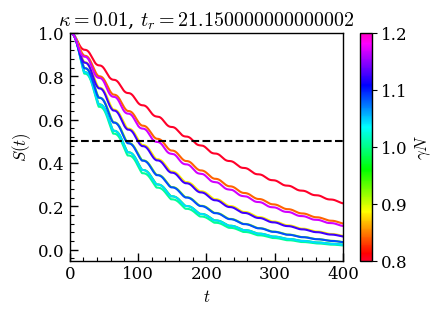

In [24]:
times = np.linspace(0,Tcutoff,int(Tcutoff/dt))
kVal = 1
rVal = 1

fig = plt.figure(figsize=(3.41667, 2*3.41667/3)) #Generate figure with a given size
ax = fig.add_axes([0, 0, 1, 1]) 

# Define colormap and normalization based on gamma values
cmap = plt.get_cmap('gist_rainbow')
norm = mpl.colors.Normalize(vmin=min(gamma_vals*N), vmax=max(gamma_vals*N))

for i in range(50)[::5]:
    color = cmap(norm(gamma_vals[i]*N))
    plt.plot(times, s_prob_arr[i,kVal,rVal,:], color=color) #label=f"$\gamma N={np.round(gamma_vals[i]*N,3)}$")
plt.plot([0,400],[0.5,0.5],ls="--",color="k")

plt.xlabel(r"$t$")
plt.ylabel(r"$S(t)$")
plt.title(f"$\kappa = {np.round(kappa_vals[kVal],2)}$, $t_r = {r_vals[rVal]*dt}$")

#plt.legend()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm) # Create a ScalarMappable for the colorbar
sm.set_array([])  # Empty array for the ScalarMappable
cbar = plt.colorbar(sm, ax=ax) # Add the colorbar to the figure
cbar.set_label(r'$\gamma N$')  # Label for the colorbar

plot_settings(None,[[0,400],[-0.05,1]],[100,20,0.2,0.04], True)
plt.show()

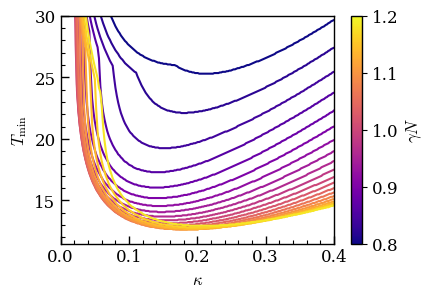

In [16]:
fig = plt.figure(figsize=(3.41667, 2*3.41667/3)) #Generate figure with a given size
ax = fig.add_axes([0, 0, 1, 1]) 

# Define colormap and normalization based on gamma values
cmap = plt.get_cmap('plasma')
norm = mpl.colors.Normalize(vmin=min(gamma_vals*N), vmax=max(gamma_vals*N))

for i in range(200)[::10]:
    color = cmap(norm(gamma_vals[i]*N))
    plt.plot(kappa_vals, T_min[i], marker="",color=color) #label=f"$\gamma N={np.round(gamma_vals[i]*N,3)}$")

plt.ylabel(r"$T_{\min}$")
plt.xlabel(r"$\kappa$")

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm) # Create a ScalarMappable for the colorbar
sm.set_array([])  # Empty array for the ScalarMappable
cbar = plt.colorbar(sm, ax=ax) # Add the colorbar to the figure
cbar.set_label(r'$\gamma N$')  # Label for the colorbar

plot_settings(None,[[0,0.4],[11.5,30]],[0.1,0.02,5,1], True)
plt.show()

### Parallel processing

In [9]:
def compute_survival_and_transition(gg, gamma, kk, kappa, rr, r, Tcutoff, dt, N, w):
    s_prob = surv_prob(Tcutoff, dt, r, N, gamma, w, kappa)
    T_val = find_transition_point(s_prob, dt)
    return (gg, kk, rr, s_prob, T_val)

# Parameters
Tcutoff = 400
dt = 0.05
r_vals = np.linspace(1, (Tcutoff+1)/dt, 20, dtype=int)
kappa_vals = np.linspace(0, 0.4, 50)
N = 100  # System size
w = 10  # Target site
gamma_vals = np.linspace(0.8/N, 1.2/N, 50)

# Storage Arrays
T_decay0p5 = np.zeros((len(gamma_vals), len(kappa_vals), len(r_vals)))
s_prob_arr = np.zeros((len(gamma_vals), len(kappa_vals), len(r_vals), int(Tcutoff / dt)))

# Create parameter list
param_list = []
for gg, gamma in enumerate(gamma_vals):
    for kk, kappa in enumerate(kappa_vals):
        for rr, r in enumerate(r_vals):
            param_list.append((gg, gamma, kk, kappa, rr, r))

# Run in parallel; here, a value of -1 means that all available cores are used
results = Parallel(n_jobs=-1)(
    delayed(compute_survival_and_transition)(
        gg, gamma, kk, kappa, rr, r, Tcutoff, dt, N, w
    )
    for (gg, gamma, kk, kappa, rr, r) in tqdm(param_list, desc="Computing", total=len(param_list))
)

# Place results into arrays
for (gg, kk, rr, s_prob, T_val) in results:
    s_prob_arr[gg, kk, rr, :] = s_prob
    T_decay0p5[gg, kk, rr] = T_val

filename = f"survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}.pkl"
dict_to_save = [gamma_vals, kappa_vals, r_vals, s_prob_arr, T_decay0p5]
with open(filename, 'wb') as f:
    pickle.dump(dict_to_save, f)

Computing:   0%|          | 0/50000 [00:00<?, ?it/s]Computing: 100%|██████████| 50000/50000 [17:40<00:00, 47.14it/s]
